In [1]:
import pandas as pd
import numpy as np
import os
import re


def seq2arr(seq):
    """
        Converts a sequence into a numerical representation.
        Arguments:
        seq: str - The sequence.
    """

    a_idx = [m.start() for m in re.finditer('a', seq)]
    c_idx = [m.start() for m in re.finditer('c', seq)]
    g_idx = [m.start() for m in re.finditer('g', seq)]
    t_idx = [m.start() for m in re.finditer('t', seq)]
    n_idx = [m.start() for m in re.finditer('-', seq)]

    seq_arr = np.full(len(seq), np.nan)
    seq_arr[a_idx] = 0
    seq_arr[c_idx] = 1
    seq_arr[g_idx] = 2
    seq_arr[t_idx] = 3
    seq_arr[n_idx] = -1

    return seq_arr

In [2]:
reg_path    = os.path.join("data", "dengue")
seq_path    = os.path.join(reg_path, "genotype", "sequences")
pheno_path  = os.path.join(reg_path, "phenotype", "antigenic")

######## DENV1 sequences ########
denv1_df    = open(os.path.join(seq_path, "d1_n1026.fas"),'r')
denv1_lines = denv1_df.readlines()

denv1_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 1026*2, 2):

    seq      = denv1_lines[i_seq+1][:-1]
    seq_name = denv1_lines[i_seq][1:-1]

    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv1_seq_df = pd.concat([df, denv1_seq_df]).reset_index(drop=True)
denv1_seq_df["virus"] = "DENV1"

#################################

#### DENV2 sequences ####
denv2_df    = open(os.path.join(seq_path, "d2_n796.fas"),'r')
denv2_lines = denv2_df.readlines()

denv2_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 796*2, 2):

    seq      = denv2_lines[i_seq+1][:-1]
    seq_name = denv2_lines[i_seq][1:-1]
    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv2_seq_df = pd.concat([df, denv2_seq_df]).reset_index(drop=True)
denv2_seq_df["virus"] = "DENV2"
############################


#### DENV3 sequences ####
denv3_df    = open(os.path.join(seq_path, "d3_n625_degap.fas"),'r')
denv3_lines = denv3_df.readlines()

denv3_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 625*2, 2):

    seq      = denv3_lines[i_seq+1][:-1]
    seq_name = denv3_lines[i_seq][1:-1]

    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv3_seq_df = pd.concat([df, denv3_seq_df]).reset_index(drop=True)
denv3_seq_df["virus"] = "DENV3"
############################


#### DENV3 sequences ####
denv4_df    = open(os.path.join(seq_path, "d4_n477.fas"),'r')
denv4_lines = denv4_df.readlines()

denv4_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 477*2, 2):

    seq      = denv4_lines[i_seq+1][:-1]
    seq_name = denv4_lines[i_seq][1:-1]

    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv4_seq_df = pd.concat([df, denv4_seq_df]).reset_index(drop=True)
denv4_seq_df["virus"] = "DENV4"
############################

denv_seq_df = pd.concat([denv1_seq_df, denv2_seq_df, denv3_seq_df, denv4_seq_df]).reset_index(drop=True)

In [3]:
def pid_arr(seq, sequences_arr):
    seq1 = seq
    seqs = sequences_arr[:, :]

    t  = seq1 == seqs
    n1 = seq1 != -1
    n2 = seqs != -1

    return np.sum(t*n1*n2, axis=1)/np.minimum(np.sum(n1), np.sum(n2, axis=1))

seq_arr    = np.array([seq2arr(seq) for seq in denv_seq_df["seq"]])
pid_mat    = np.array([pid_arr(seq, seq_arr) for seq in seq_arr])
pid_arr_df = pd.DataFrame(data=pid_mat, columns=denv_seq_df["seq_name"], index=denv_seq_df["seq_name"])


In [4]:
anti_map_2d_df             = pd.read_csv(os.path.join(pheno_path, "ac2D_coords_Thai.csv"))
anti_map_2d_df             = anti_map_2d_df.dropna(subset=["strainID"]) # DROP 3 row THAT ARE NANs
anti_map_2d_df["serotype"] = anti_map_2d_df["sero"].apply(lambda x: "DENV{}".format(x))


In [5]:
antigenic_mat_arr = np.full((len(anti_map_2d_df), len(anti_map_2d_df)), np.nan)

for i in range(len(anti_map_2d_df)):
    for j in range(i, len(anti_map_2d_df)):
        strain1 = anti_map_2d_df["strainID"].iloc[i]
        strain2 = anti_map_2d_df["strainID"].iloc[j]

        strain1_df = anti_map_2d_df[anti_map_2d_df.strainID.isin([strain1, strain2])]
        if len(strain1_df) == 1:
            anti_dis = 0
        else:
            anti_dis = np.sqrt((strain1_df["coord1"].values[0]-strain1_df["coord1"].values[1])**2 +
                               (strain1_df["coord2"].values[0]-strain1_df["coord2"].values[1])**2)
        antigenic_mat_arr[i, j] = anti_dis
ant_mat_df = pd.DataFrame(data=antigenic_mat_arr, columns=anti_map_2d_df["strainID"], index=anti_map_2d_df["strainID"])


In [6]:
import itertools
def flatten_list(l):
    return list(itertools.chain.from_iterable(l))


antigen_dist_df               = pd.melt(ant_mat_df.reset_index(), value_vars=ant_mat_df.index.values)
antigen_dist_df['strain2_id'] = flatten_list([list(ant_mat_df.index.values)]*len(ant_mat_df))
antigen_dist_df               = antigen_dist_df.rename(columns={"value": "antigenic_distance",
                                    "strainID": "strain1_id"})[["strain1_id", "strain2_id", "antigenic_distance"]]
antigen_dist_df               = antigen_dist_df.dropna() # drop because order does not matter

In [7]:
pid_df               = pd.melt(pid_arr_df.reset_index(), value_vars=denv_seq_df.seq_name.values)
pid_df['seq2_name']  = flatten_list([list(denv_seq_df.seq_name.values)]*len(denv_seq_df))
pid_df               = pid_df.rename(columns={"value":"pid", "seq_name":"seq1_name"})[["seq1_name", "seq2_name", "pid"]]

pid_df["strain1_id"] = pid_df["seq1_name"].apply(lambda x: x.split(" ")[-1])
pid_df["strain2_id"] = pid_df["seq2_name"].apply(lambda x: x.split(" ")[-1])

In [13]:

pid_merge_df = pid_df.copy()
pid_merge_df = pid_merge_df[pid_merge_df.strain1_id.isin(list(antigen_dist_df.strain1_id.values))]
pid_merge_df = pid_merge_df[pid_merge_df.strain2_id.isin(list(antigen_dist_df.strain1_id.values))]

data_reg_df = pd.merge(antigen_dist_df, pid_merge_df, on=["strain1_id", "strain2_id"], how="inner")

strainid2serotype = {r.strainID: r.serotype for _, r in anti_map_2d_df[["strainID", "serotype"]].iterrows()}

data_reg_df["serotype1"] = data_reg_df["strain1_id"].map(strainid2serotype)
data_reg_df["serotype2"] = data_reg_df["strain2_id"].map(strainid2serotype)

data_reg_df = data_reg_df[["strain1_id", "strain2_id",  "pid", "antigenic_distance", "serotype1", "serotype2"]]
data_reg_df = data_reg_df.dropna().sort_values(by=["serotype1", "serotype2"]).reset_index(drop=True)
data_reg_df

,strain1_id,strain2_id,pid,antigenic_distance,serotype1,serotype2
0,00532/94,00532/94,1.000000,0.000000,DENV1,DENV1
1,00817/94,00532/94,0.961882,0.380036,DENV1,DENV1
2,00817/94,00817/94,0.999902,0.000000,DENV1,DENV1
3,01495/94,00532/94,0.962374,0.563290,DENV1,DENV1
4,01495/94,00817/94,0.995481,0.494402,DENV1,DENV1
...,...,...,...,...,...,...
75850,00615/14,01012/13,0.995474,1.654285,DENV4,DENV4
75851,00615/14,00214/14,0.994884,1.572135,DENV4,DENV4
75852,00615/14,00555/14,0.993998,0.295227,DENV4,DENV4
75853,00615/14,00595/14,0.989079,0.996336,DENV4,DENV4


In [17]:
center_map_sero_df    = anti_map_2d_df.groupby("serotype").agg({"coord1": "mean", "coord2":"mean"}).reset_index()
center_map_df         = pd.DataFrame(data=["center_mass", anti_map_2d_df["coord1"].mean(),
                                                        anti_map_2d_df["coord2"].mean()]).T
center_map_df.columns = ["serotype", "coord1", "coord2"]
center_map_sero_df    = pd.concat([center_map_df, center_map_sero_df]).reset_index(drop=True)


In [23]:
def distance_center_of_serotype(strain_id, anti_map_df, center_map_df, serotype):

    x = anti_map_df[anti_map_df.strainID == strain_id]["coord1"].values[0]
    y = anti_map_df[anti_map_df.strainID == strain_id]["coord2"].values[0]

    x_center = center_map_df[center_map_df.serotype == serotype]["coord1"].values[0]
    y_center = center_map_df[center_map_df.serotype == serotype]["coord2"].values[0]

    return np.sqrt((x-x_center)**2 + (y-y_center)**2)

Di_si = lambda strain_id, serotype: distance_center_of_serotype(strain_id, anti_map_2d_df, center_map_sero_df, serotype)

data_reg_df["D1_s1"] = data_reg_df.apply(lambda x: Di_si(x.strain1_id, x.serotype1), axis=1)
data_reg_df["D2_s2"] = data_reg_df.apply(lambda x: Di_si(x.strain2_id, x.serotype2), axis=1)

In [25]:
data_reg_df["abs(D1_s1_D2_s2)"] = np.abs(data_reg_df["D1_s1"] - data_reg_df["D2_s2"])
data_reg_df

,strain1_id,strain2_id,pid,antigenic_distance,serotype1,serotype2,D1_s1,D2_s2,abs(D1_s1_D2_s2)
0,00532/94,00532/94,1.000000,0.000000,DENV1,DENV1,0.545619,0.545619,0.000000
1,00817/94,00532/94,0.961882,0.380036,DENV1,DENV1,0.857055,0.545619,0.311436
2,00817/94,00817/94,0.999902,0.000000,DENV1,DENV1,0.857055,0.857055,0.000000
3,01495/94,00532/94,0.962374,0.563290,DENV1,DENV1,0.677792,0.545619,0.132173
4,01495/94,00817/94,0.995481,0.494402,DENV1,DENV1,0.677792,0.857055,0.179263
...,...,...,...,...,...,...,...,...,...
75850,00615/14,01012/13,0.995474,1.654285,DENV4,DENV4,0.137309,1.604013,1.466704
75851,00615/14,00214/14,0.994884,1.572135,DENV4,DENV4,0.137309,1.470040,1.332730
75852,00615/14,00555/14,0.993998,0.295227,DENV4,DENV4,0.137309,0.202182,0.064873
75853,00615/14,00595/14,0.989079,0.996336,DENV4,DENV4,0.137309,0.974916,0.837606


In [26]:
data_reg_df.to_csv(os.path.join("data", "dengue", "regression", "regression.csv"), index=False)

Text(95.7222222222222, 0.5, '')

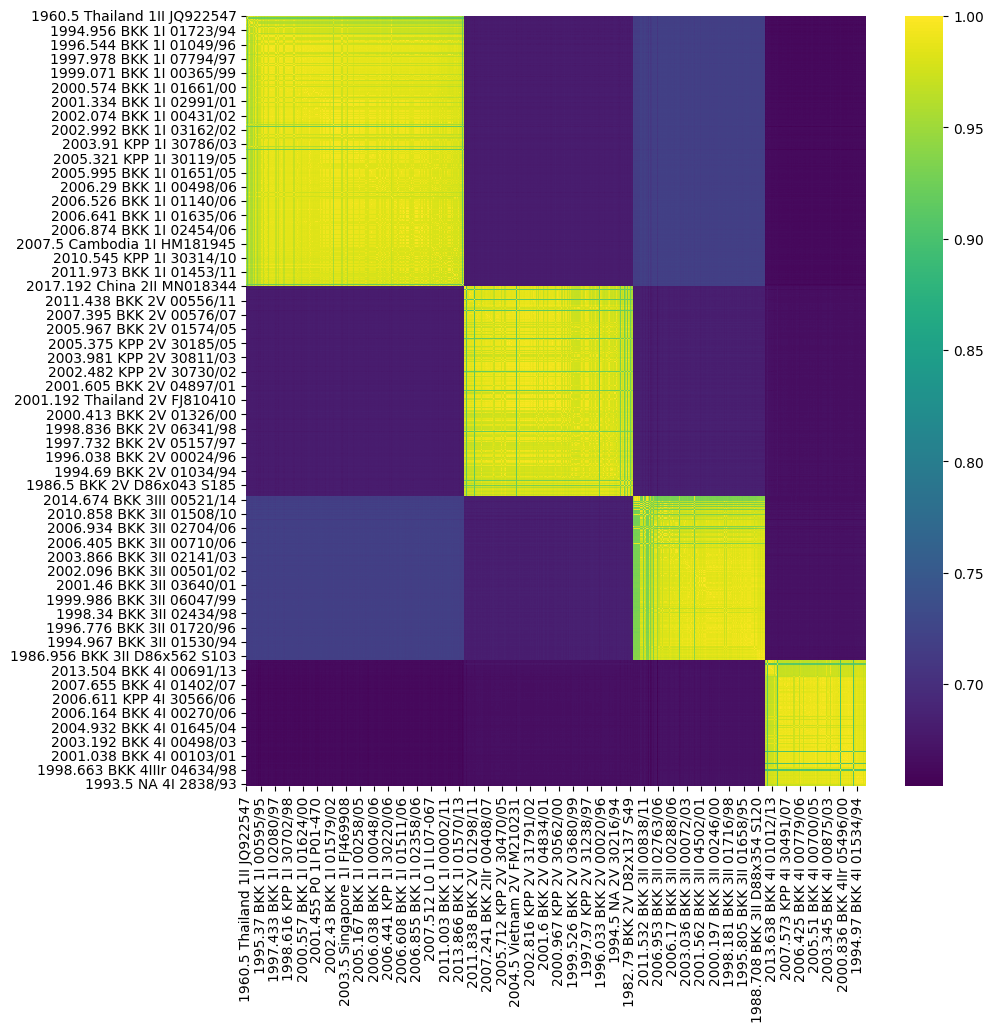

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(pid_arr_df, ax=ax, cmap="viridis")

ax.set_xlabel(None)
ax.set_ylabel(None)

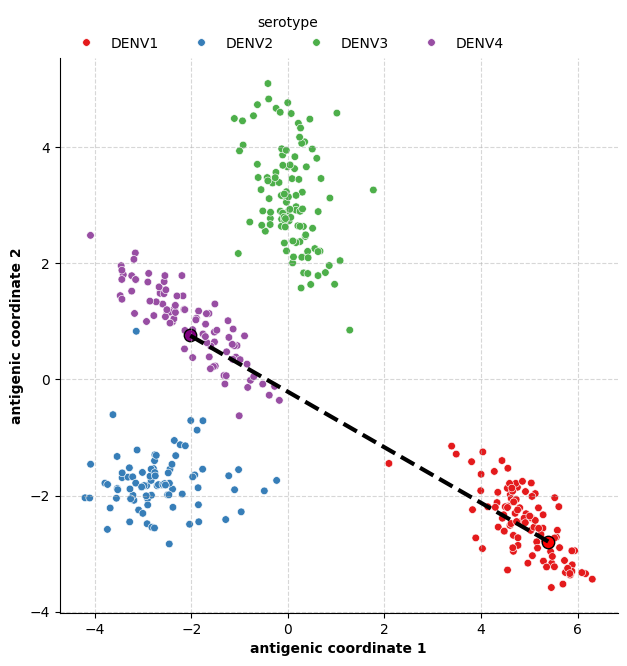

In [28]:
anti_map_2d_df             = pd.read_csv(os.path.join(pheno_path, "ac2D_coords_Thai.csv"))
anti_map_2d_df             = anti_map_2d_df.dropna(subset=["strainID"]) # DROP 3 row THAT ARE NANs
anti_map_2d_df["serotype"] = anti_map_2d_df["sero"].apply(lambda x: "DENV{}".format(x))

strain1 = "00532/94"
strain2 = "00555/14"

strain1_df = anti_map_2d_df[anti_map_2d_df.strainID==strain1]
strain2_df = anti_map_2d_df[anti_map_2d_df.strainID==strain2]

fig, ax = plt.subplots(1, 1, figsize=(7.2, 7.2))
sns.scatterplot(data = anti_map_2d_df,
            x        = "coord1",
            y        = "coord2",
            hue      = "serotype",
            palette  = "Set1",
            s        = 30,
            ec       = "w")

ax.scatter(strain1_df["coord1"], strain1_df["coord2"], color="red", ec="k", s=80)
ax.scatter(strain2_df["coord1"], strain2_df["coord2"], color="purple", ec="k", s=80)

ax.plot([strain1_df["coord1"].values[0], strain2_df["coord1"].values[0]], [strain1_df["coord2"].values[0], strain2_df["coord2"].values[0]],
        color="black", linestyle="--", lw=3)

ax.legend(loc='upper left', bbox_to_anchor=(0., 1.1), title="serotype", ncol=4, frameon=False)
ax.set_xlabel("antigenic coordinate 1", weight="bold")
ax.set_ylabel("antigenic coordinate 2", weight="bold")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.grid(True, linestyle='--', alpha=0.5)



Text(64.47222222222221, 0.5, '')

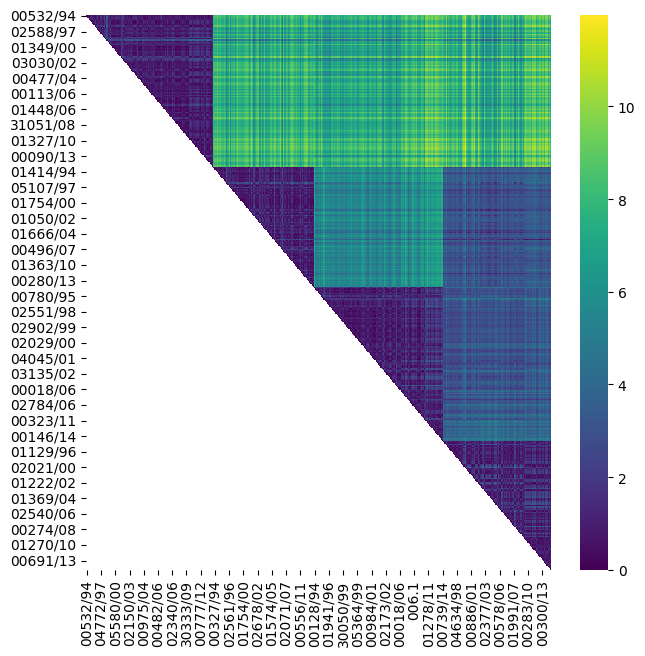

In [29]:
ant_mat_df = pd.DataFrame(data=antigenic_mat_arr, columns=anti_map_2d_df["strainID"], index=anti_map_2d_df["strainID"])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.2))

sns.heatmap(ant_mat_df, ax=ax, cmap="viridis")

ax.set_xlabel(None)
ax.set_ylabel(None)